In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
import seaborn as sns
plt.style.use('seaborn-deep')

看数据

In [2]:
#特征看起来是连续的，标签是01，该任务是二分类任务

pf = pd.read_csv("predict_failure.csv")
pf.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
pf.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [4]:
#共124494条数据
pf['failure'].count()

124494

In [5]:
#日期数
#设备数
#最后一天

print(len(pf['date'].unique()))
print(len(pf['device'].unique()))
print(pf.iloc[-1,:])

304
1168
date          2015-11-02
device          Z1F0QLC1
failure                0
attribute1      17572840
attribute2             0
attribute3             0
attribute4             0
attribute5            10
attribute6        351431
attribute7             0
attribute8             0
attribute9             0
Name: 124493, dtype: object


In [6]:
# 0,1个数，可以看出样本极其不平衡
pf['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

预处理

In [7]:
# 无nan
pf.isnull().values.any()

False

In [8]:
# 和日期是否有关系

pf_tmp = pd.DataFrame(pf, columns=['date','failure'])
pf_tmp.head()

,date,failure
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
4,2015-01-01,0


In [9]:
date = pf['date'].unique()
i = 0
count = [0] * (len(pf['date'].unique()))
for ind in range(pf['failure'].count()):
    if pf_tmp.iloc[ind,0] == date[i]:
        count[i] += pf_tmp.iloc[ind,1]
    else:
        if i == len(pf['date'].unique())-1:
            break
        else:
            count[i+1] += pf_tmp.iloc[ind,1]
            i += 1
count_df = pd.DataFrame({'count':count})
count_df.set_index(date,inplace=True)
count_df

,count
2015-01-01,0
2015-01-02,0
2015-01-03,0
2015-01-04,0
2015-01-05,1
...,...
2015-10-27,0
2015-10-29,0
2015-10-30,0
2015-10-31,0


In [10]:
pf_tmp.drop_duplicates(subset=['date'], keep='first', inplace=True)
pf_tmp.set_index(['date'],inplace=True)
pf_tmp

,failure
date,
2015-01-01,0
2015-01-02,0
2015-01-03,0
2015-01-04,0
2015-01-05,0
...,...
2015-10-27,0
2015-10-29,0
2015-10-30,0


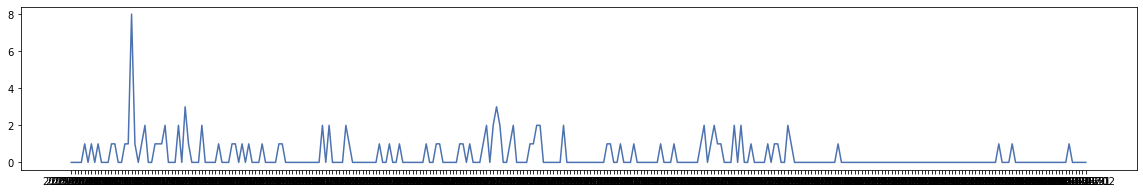

In [11]:
pf_tmp = pd.concat([pf_tmp,count_df],axis=1)
# pf_tmp['count'] = count_df['count']
pf_tmp = pf_tmp.drop(['failure'],axis=1)
pf_tmp_ts = pf_tmp['2015-01-01':'2015-11-02']
fig,ax =  plt.subplots(1,figsize=(20,3))

ax.plot(pf_tmp_ts)

plt.show()

##似乎和时间没有绝对关系，因此不使用周期性特征（三角函数）来表示日期，直接放缩在0-1间就行

In [12]:
for i in range(len(pf.date)):
    pf.iloc[i,0] = datetime.strptime(pf.iloc[i,0],'%Y-%m-%d')

timestamp_s = pf.date.map(datetime.timestamp)
pf['timestamp'] = timestamp_s

In [13]:
pf = pf.drop(['date'],axis=1)
pf

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,timestamp
0,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1.420042e+09
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,1.420042e+09
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,1.420042e+09
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,1.420042e+09
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,1.420042e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,1.446394e+09
124490,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,1.446394e+09
124491,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,1.446394e+09
124492,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,1.446394e+09


In [14]:
# 和具体的设备是否有关系

pf_tmp = pd.DataFrame(pf, columns=['device','failure'])
pf_tmp.head()

,device,failure
0,S1F01085,0
1,S1F0166B,0
2,S1F01E6Y,0
3,S1F01JE0,0
4,S1F01R2B,0


In [15]:
pf_tmp = pf_tmp.sort_values(by=['device'])
device = pf_tmp['device'].unique()
i = 0
count = [0] * (len(pf['device'].unique()))
for ind in range(pf['failure'].count()):
    if pf_tmp.iloc[ind,0] == device[i]:
        count[i] += pf_tmp.iloc[ind,1]
    else:
        if i == len(pf['device'].unique())-1:
            break
        else:
            count[i+1] += pf_tmp.iloc[ind,1]
            i += 1
count_df = pd.DataFrame({'count':count})
count_df.set_index(device,inplace=True)
count_df

,count
S1F01085,0
S1F013BB,0
S1F0166B,0
S1F01E6Y,0
S1F01JE0,0
...,...
Z1F1VMZB,0
Z1F1VQFY,1
Z1F26YZB,0
Z1F282ZV,0


In [16]:
count_df['count'].value_counts()

0    1062
1     106
Name: count, dtype: int64

In [17]:
pf_tmp.drop_duplicates(subset=['device'], keep='first', inplace=True)
pf_tmp.set_index(['device'],inplace=True)
pf_tmp

,failure
device,
S1F01085,0
S1F013BB,0
S1F0166B,0
S1F01E6Y,0
S1F01JE0,0
...,...
Z1F1VMZB,0
Z1F1VQFY,0
Z1F26YZB,0


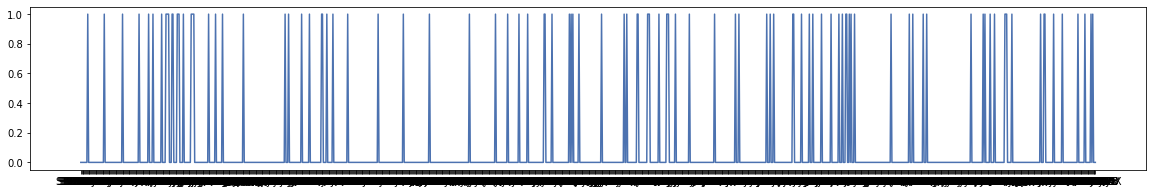

In [18]:
pf_tmp = pd.concat([pf_tmp,count_df],axis=1)
# pf_tmp['count'] = count_df['count']
pf_tmp = pf_tmp.drop(['failure'],axis=1)
pf_tmp_ts = pf_tmp[:]
fig,ax =  plt.subplots(1,figsize=(20,3))

ax.plot(pf_tmp_ts)

plt.show()

##似乎和设备没有绝对关系，不使用设备名作为特征

In [19]:
pf = pf.drop(['device'],axis=1)
pf

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,timestamp
0,0,215630672,56,0,52,6,407438,0,0,7,1.420042e+09
1,0,61370680,0,3,0,6,403174,0,0,0,1.420042e+09
2,0,173295968,0,0,0,12,237394,0,0,0,1.420042e+09
3,0,79694024,0,0,0,6,410186,0,0,0,1.420042e+09
4,0,135970480,0,0,0,15,313173,0,0,3,1.420042e+09
...,...,...,...,...,...,...,...,...,...,...,...
124489,0,18310224,0,0,0,10,353705,8,8,0,1.446394e+09
124490,0,172556680,96,107,4,11,332792,0,0,13,1.446394e+09
124491,0,19029120,4832,0,0,11,350410,0,0,0,1.446394e+09
124492,0,226953408,0,0,0,12,358980,0,0,0,1.446394e+09


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler_a1 = MinMaxScaler(feature_range=(0, 1)).fit(pf[["attribute1"]])
pf_normalized = pd.DataFrame(scaler.fit_transform(pf),
                             columns = pf.columns.values,
                            index = pf.index)

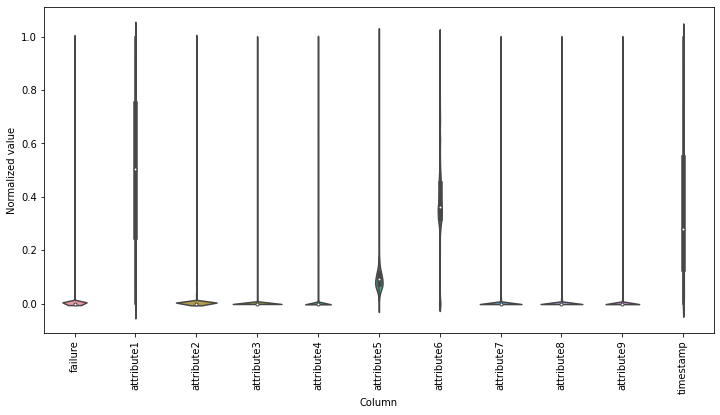

In [21]:
melt_plot = pf_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(pf_normalized.keys(), rotation=90)

数据集划分与数据增强

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = pf_normalized.iloc[:,1:]
y = pf_normalized.failure

smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X,y)
print(Counter(y_smo))

Counter({0.0: 124388, 1.0: 124388})


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_smo, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_smo, test_size=0.2, random_state=42)

In [51]:
# print(X_train[:5])
print(type(X_train))
# print(X_test[:5])
# print(y_train[:5])
print(type(y_train))
# print(y_test[:5])

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


训练

逻辑回归

In [27]:
#网格搜索

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'C':[1.0,5.0,10.0,100.0]},
]

lr = LogisticRegression(random_state=1,max_iter=300)

grid_search = GridSearchCV(lr, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
lr = grid_search.best_estimator_

# lr.fit(X_train,y_train)
# print("Class:",lr.classes_)
# print("Coef:",lr.coef_)
# print("intercept",lr.intercept_)
# print("n_iter",lr.n_iter_)

KeyboardInterrupt: 

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#F1,recall,precision,acc

lr_pres = lr.predict(X_test) # 使用训练好的模型lr对X_test进行预测
# print('acc：',accuracy_score(y_test, lr_pres))
# print('precision：',precision_score(y_test, lr_pres))
# print('recall：',recall_score(y_test, lr_pres))
print(classification_report(y_test,lr_pres))

              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83     24752
         1.0       0.95      0.65      0.77     25004

    accuracy                           0.81     49756
   macro avg       0.84      0.81      0.80     49756
weighted avg       0.84      0.81      0.80     49756



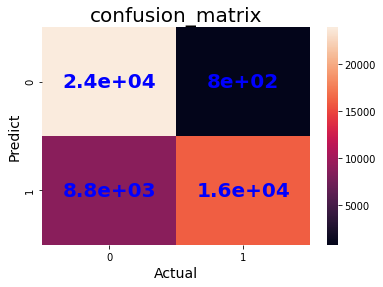

In [27]:
# 混淆矩阵热点图
cm = confusion_matrix(y_test, lr_pres, labels=[0,1]) 
sns.heatmap(cm, annot = True, annot_kws={'size':20,'weight':'bold', 'color':'blue'})
plt.rc('font', family='Arial Unicode MS', size=14)
plt.title('confusion_matrix',fontsize=20)
plt.xlabel('Actual',fontsize=14)
plt.ylabel('Predict',fontsize=14)
plt.show()

findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.


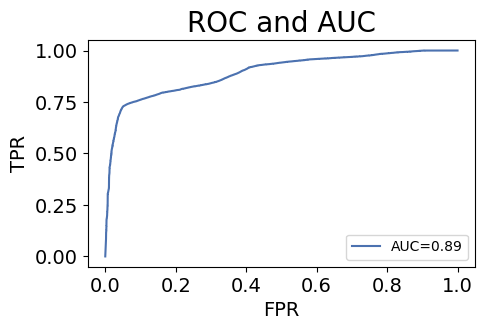

In [28]:
# ROC曲线和AUC

lr_pres_proba = lr.predict_proba(X_test) [::, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_pres_proba)
auc = roc_auc_score(y_test, lr_pres_proba)
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(fpr, tpr, label="AUC={:.2f}" .format(auc))
plt.legend(loc=4, fontsize=10)
plt.title('ROC and AUC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

SVM

In [50]:
from sklearn.svm import SVC

param_grid = [
    {'kernel':['linear'], 'C':[0.5,1.0,5.0]},
    {'kernel':['poly'], 'C':[1.0,5.0], 'degree':[2,3,4,5], 'gamma':[0.2,1.0]},
    {'kernel':['rbf'], 'C':[0.5,1.0,5.0], 'gamma':[0.2,1.0,10.0]},
]

svm = SVC(random_state=1,probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=3,
                          scoring='neg_mean_squared_error',n_jobs = -1)
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
svm = grid_search.best_estimator_

{'C': 5.0, 'gamma': 10.0, 'kernel': 'rbf'}


In [51]:
svm_pres = svm.predict(X_test)
print(classification_report(y_test,svm_pres))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     24752
         1.0       0.95      0.99      0.97     25004

    accuracy                           0.97     49756
   macro avg       0.97      0.97      0.97     49756
weighted avg       0.97      0.97      0.97     49756



In [55]:
svm_pres_proba = svm.predict_proba(X_test) [::, 1]
fpr, tpr, thresholds = roc_curve(y_test, svm_pres_proba)
auc = roc_auc_score(y_test, svm_pres_proba)
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(fpr, tpr, label="AUC={:.2f}" .format(auc))
plt.legend(loc=4, fontsize=10)
plt.title('ROC and AUC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

AttributeError: predict_proba is not available when  probability=False

gradient tree decision tree: lightgbm (对应则不使用Xgboost，RF)

In [28]:
from lightgbm import LGBMClassifier

gbm = LGBMClassifier(num_leaves=31)
# gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)

param_grid = [
    {'learning_rate': [0.01, 0.1, 0.05, 0.001], 'n_estimators': [20, 40]}
]

grid_search = GridSearchCV(gbm, param_grid, cv=3,
                          scoring='neg_log_loss',n_jobs = -1)
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
gbm = grid_search.best_estimator_

{'learning_rate': 0.1, 'n_estimators': 40}


In [30]:
gbm_pres = gbm.predict(X_test)
print(classification_report(y_test,gbm_pres))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     24752
         1.0       0.98      1.00      0.99     25004

    accuracy                           0.99     49756
   macro avg       0.99      0.99      0.99     49756
weighted avg       0.99      0.99      0.99     49756



In [45]:
original_res_proba = gbm.predict_proba(X)
original_res = gbm.predict(X)
print(original_res_proba[:5])
print(original_res[:5])

[[0.96854127 0.03145873]
 [0.98793807 0.01206193]
 [0.9911029  0.0088971 ]
 [0.9890391  0.0109609 ]
 [0.98184728 0.01815272]]
[0. 0. 0. 0. 0.]


In [46]:
res = []
for i in range(len(X)):
    if int(original_res[i]) == 0:
        res.append('{}, {}'.format(int(original_res[i]), original_res_proba[::,0][i]))
    else:
        res.append('{}, {}'.format(int(original_res[i]), original_res_proba[::,1][i]))
res_df = pd.DataFrame({'result': res})

In [47]:
res_df.head()

,result
0,"0, 0.9685412740025523"
1,"0, 0.9879380673436704"
2,"0, 0.9911028985041278"
3,"0, 0.9890391015649032"
4,"0, 0.9818472838792613"


In [48]:
pf_original = pd.read_csv("predict_failure.csv")
pf_original['result'] = res_df
pf_original.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,result
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,"0, 0.9685412740025523"
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,"0, 0.9879380673436704"
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,"0, 0.9911028985041278"
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,"0, 0.9890391015649032"
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,"0, 0.9818472838792613"


In [49]:
pf_original.to_csv('result.csv')

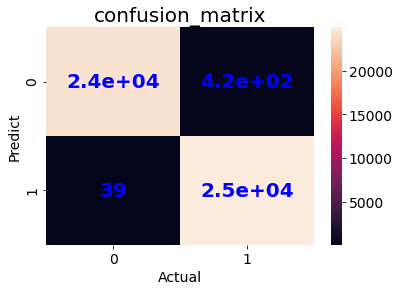

In [32]:
cm = confusion_matrix(y_test, gbm_pres, labels=[0,1]) 
sns.heatmap(cm, annot = True, annot_kws={'size':20,'weight':'bold', 'color':'blue'})
plt.rc('font', family='Arial Unicode MS', size=14)
plt.title('confusion_matrix',fontsize=20)
plt.xlabel('Actual',fontsize=14)
plt.ylabel('Predict',fontsize=14)
plt.show()

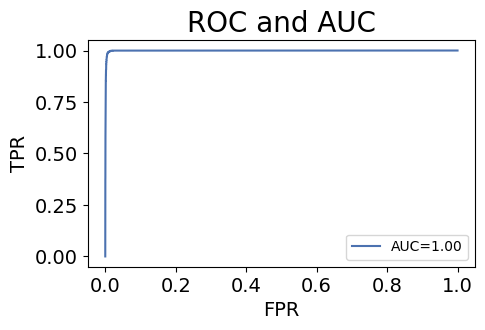

In [60]:
gbm_pres_proba = gbm.predict_proba(X_test) [::, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbm_pres_proba)
auc = roc_auc_score(y_test, gbm_pres_proba)
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(fpr, tpr, label="AUC={:.2f}" .format(auc))
plt.legend(loc=4, fontsize=10)
plt.title('ROC and AUC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric='minkowski')

param_grid = [
    {'n_neighbors': [2,5,10,15,20], 'weights': ['uniform', 'distance'], 'p':[1,2]}
]

grid_search = GridSearchCV(knn, param_grid, cv=3,
                          scoring='neg_log_loss',n_jobs = -1)
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
knn = grid_search.best_estimator_

{'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


In [63]:
knn_pres = knn.predict(X_test)
print(classification_report(y_test,knn_pres))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     24752
         1.0       0.98      1.00      0.99     25004

    accuracy                           0.99     49756
   macro avg       0.99      0.99      0.99     49756
weighted avg       0.99      0.99      0.99     49756



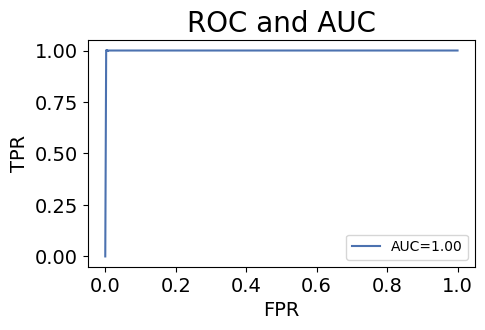

In [64]:
knn_pres_proba = knn.predict_proba(X_test) [::, 1]
fpr, tpr, thresholds = roc_curve(y_test, knn_pres_proba)
auc = roc_auc_score(y_test, knn_pres_proba)
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(fpr, tpr, label="AUC={:.2f}" .format(auc))
plt.legend(loc=4, fontsize=10)
plt.title('ROC and AUC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

贝叶斯
如果样本特征的分布大部分是连续值，适用GaussianNB会比较好。
如果样本特征的分布大部分是多元离散值，使用MultinomialNB比较合适。
而如果样本特征是二元离散值或者很稀疏的多元离散值，应该使用BernoulliNB。

In [66]:
#使用高斯
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [67]:
gnb_pres = gnb.predict(X_test)
print(classification_report(y_test,gnb_pres))

              precision    recall  f1-score   support

         0.0       0.56      0.99      0.72     24752
         1.0       0.98      0.23      0.37     25004

    accuracy                           0.61     49756
   macro avg       0.77      0.61      0.54     49756
weighted avg       0.77      0.61      0.54     49756



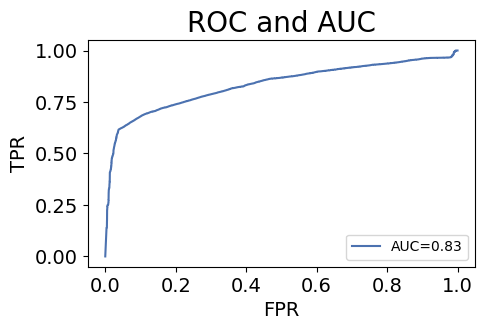

In [68]:
gnb_pres_proba = gnb.predict_proba(X_test) [::, 1]
fpr, tpr, thresholds = roc_curve(y_test, gnb_pres_proba)
auc = roc_auc_score(y_test, gnb_pres_proba)
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(fpr, tpr, label="AUC={:.2f}" .format(auc))
plt.legend(loc=4, fontsize=10)
plt.title('ROC and AUC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

In [72]:
import pickle

lr_path = 'lr.pkl'
pickle.dump(lr, open(lr_path, 'wb'), protocol=4)

svm_path = 'svm.pkl'
pickle.dump(svm, open(svm_path, 'wb'), protocol=4)

gbm_path = 'gbm.pkl'
pickle.dump(gbm, open(gbm_path, 'wb'), protocol=4)

knn_path = 'knn.pkl'
pickle.dump(knn, open(knn_path, 'wb'), protocol=4)

gnb_path = 'gnb.pkl'
pickle.dump(gnb, open(gnb_path, 'wb'), protocol=4)

In [ ]:
gbm = pickle.load(gbm_path)